# **Jax**

In [1]:
# make sure jax is using the gpu
from jax.lib import xla_bridge
print(f"JAX device: {xla_bridge.get_backend().platform}")

#rest of the imports
import jax
import jax.numpy as jnp
from jax import vmap
from sine_gaussian_jax import SineGaussianJax

JAX device: gpu


In [2]:
sample_rate = 4096.0
duration = 10.0

sg_jax = SineGaussianJax(sample_rate, duration)

quality = jnp.linspace(3, 100, 1000)
frequency = jnp.logspace(1, 3, 1000)
hrss = jnp.logspace(-23, -6, 1000)
phase = jnp.linspace(0, 2 * jnp.pi, 1000)
eccentricity = jnp.linspace(0, 0.99, 1000)

_ = sg_jax(quality, frequency, hrss, phase, eccentricity) # warm up

#benchmark speed
print("\nRegular Jax")
%timeit -n 10 -r 100 sg_jax(quality, frequency, hrss, phase, eccentricity) 

sg_jit = jax.jit(sg_jax)
_ = sg_jit(quality, frequency, hrss, phase, eccentricity) # warm up

print("\nJax with JIT")
%timeit -n 100 -r 100 sg_jit(quality, frequency, hrss, phase, eccentricity)

sg_vmap = vmap(sg_jax, in_axes=(0, 0, 0, 0, 0))
_ = sg_vmap(quality, frequency, hrss, phase, eccentricity) # warm up

print("\nUsing vmap")
%timeit -n 10 -r 100 sg_vmap(quality, frequency, hrss, phase, eccentricity)

# split each parameter into a batch of 10 
batched_quality = jnp.stack(jnp.split(quality, 10))
batched_frequency = jnp.stack(jnp.split(frequency, 10))
batched_hrss = jnp.stack(jnp.split(hrss, 10))
batched_phase = jnp.stack(jnp.split(phase, 10))
batched_eccentricity = jnp.stack(jnp.split(eccentricity, 10))

print("\nUsing vmap with split")
%timeit -n 10 -r 100 sg_vmap(batched_quality, batched_frequency, batched_hrss, batched_phase, batched_eccentricity)

# jit the vmap
sg_jit_vmap = jax.jit(sg_vmap)
_ = sg_jit_vmap(batched_quality, batched_frequency, batched_hrss, batched_phase, batched_eccentricity) # warm up

print("\nUsing vmap with JIT")
%timeit -n 100 -r 100 sg_jit_vmap(batched_quality, batched_frequency, batched_hrss, batched_phase, batched_eccentricity)

2024-06-03 12:01:39.841721: W external/xla/xla/service/gpu/nvptx_compiler.cc:760] The NVIDIA driver's CUDA version is 12.2 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.



Regular Jax
10.9 ms ± 163 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)

Jax with JIT
1.49 ms ± 47.3 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)

Using vmap
20.9 ms ± 301 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)

Using vmap with split
20.7 ms ± 5.5 ms per loop (mean ± std. dev. of 100 runs, 10 loops each)

Using vmap with JIT
1.49 ms ± 47.1 µs per loop (mean ± std. dev. of 100 runs, 100 loops each)


# **Torch**

In [1]:
# make sure torch is using the gpu
import torch
print(f"Torch GPU Available: {torch.cuda.is_available()}, {torch.cuda.get_device_name(0)}")

#rest of the imports
import numpy as np
from sine_gaussian import SineGaussian

Torch GPU Available: True, GRID A100X-20C


In [2]:
sample_rate = 4096.0
duration = 10.0

sg_torch = SineGaussian(sample_rate, duration)

quality = torch.linspace(3, 100, 1000).cuda()
frequency = torch.logspace(1, 3, 1000).cuda()
hrss = torch.logspace(-23, -6, 1000).cuda()
phase = torch.linspace(0, 2 * np.pi, 1000).cuda()
eccentricity = torch.linspace(0, 0.99, 1000).cuda()

sg_torch = sg_torch.cuda()

_ = sg_torch(quality, frequency, hrss, phase, eccentricity) # warm up

#benchmark speed
%timeit -n 10 -r 100 sg_torch(quality, frequency, hrss, phase, eccentricity)

7.12 ms ± 54 µs per loop (mean ± std. dev. of 100 runs, 10 loops each)


# **Comparision**

In [1]:
import matplotlib.pyplot as plt

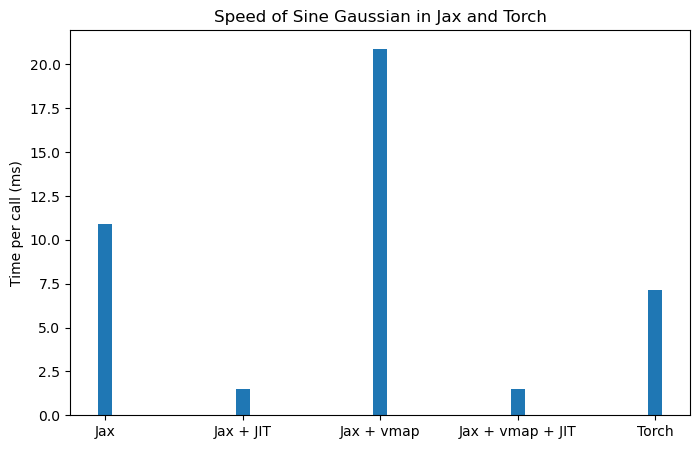

In [2]:
results = [10.9, 1.49, 20.9, 1.49, 7.12]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.bar(["Jax", "Jax + JIT", "Jax + vmap", "Jax + vmap + JIT", "Torch"], results, width=0.1)
ax.set_ylabel("Time per call (ms)")
ax.set_title("Speed of Sine Gaussian in Jax and Torch")
plt.show()